In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.dates as mdates

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF files, extracts and aggregates the capacity factor data for each configuration, and constructs a matrix where each row is a SPORE configuration and each column is a timestep.

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_df = data['capacity_factor'].to_dataframe().reset_index()
    data_df = data_df[~data_df['techs'].str.contains(r'_to_', regex=True)]
    data_df = data_df.dropna(subset=['capacity_factor'])
    data_df['capacity_factor'] = data_df['capacity_factor'] / 3
    
    # Aggregate the source capacities by tech
    aggregated_source_cap = data_df.groupby('timesteps')['capacity_factor'].mean().reset_index()   # mean or sum
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_source_cap.set_index('timesteps')['capacity_factor']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_source_cap['timesteps']

# Show the resulting matrix
aggregated_matrix


timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-01-06 18:00:00,2019-01-06 21:00:00,2019-01-07 00:00:00,2019-01-07 03:00:00,2019-01-07 06:00:00,2019-01-07 09:00:00,2019-01-07 12:00:00,2019-01-07 15:00:00,2019-01-07 18:00:00,2019-01-07 21:00:00
spores\maxbat_spore_1,0.220004,0.223897,0.226115,0.229866,0.230326,0.229238,0.233132,0.232003,0.231613,0.228544,...,0.290619,0.278596,0.225449,0.241736,0.340003,0.275362,0.225190,0.231063,0.238246,0.244856
spores\maxbat_spore_2,0.217397,0.220596,0.222097,0.226028,0.226631,0.224829,0.228748,0.228018,0.227847,0.224150,...,0.291879,0.281424,0.228430,0.241059,0.328063,0.271291,0.220816,0.226479,0.233841,0.237379
spores\maxbat_spore_3,0.220880,0.223579,0.225395,0.228886,0.229522,0.227645,0.231715,0.230905,0.230286,0.227303,...,0.293956,0.276916,0.224709,0.239136,0.333731,0.272414,0.222613,0.228869,0.236815,0.242373
spores\maxbat_spore_4,0.225141,0.227253,0.229310,0.233942,0.234264,0.233152,0.237146,0.236097,0.234722,0.232521,...,0.295293,0.282498,0.233186,0.245638,0.341361,0.278268,0.229953,0.235505,0.241875,0.247523
spores\maxbat_spore_5,0.222436,0.223853,0.225716,0.229766,0.230296,0.229365,0.233192,0.232153,0.231573,0.231623,...,0.287568,0.274863,0.229922,0.247291,0.337439,0.276274,0.227127,0.232370,0.238834,0.244136
spores\maxbio_spore_1,0.218226,0.221405,0.223057,0.224417,0.227322,0.230727,0.233758,0.231637,0.230727,0.228027,...,0.221120,0.209100,0.205514,0.209373,0.230986,0.230230,0.230417,0.235492,0.238016,0.242782
spores\maxbio_spore_2,0.206320,0.210583,0.212561,0.216336,0.219758,0.220564,0.223676,0.222315,0.221681,0.218464,...,0.194170,0.190365,0.189691,0.191802,0.202411,0.207560,0.214233,0.221273,0.226452,0.231814
spores\maxbio_spore_3,0.224274,0.228490,0.230226,0.233935,0.236369,0.239220,0.242612,0.241337,0.240334,0.234646,...,0.219211,0.213944,0.211137,0.211455,0.226177,0.231747,0.232703,0.238353,0.240671,0.252938
spores\maxbio_spore_4,0.272613,0.277550,0.279334,0.283454,0.285758,0.287856,0.291279,0.290533,0.289559,0.283250,...,0.253403,0.252302,0.250031,0.250404,0.261085,0.267891,0.275475,0.283174,0.287355,0.300269
spores\maxbio_spore_5,0.206637,0.211429,0.213638,0.217844,0.221368,0.219841,0.224129,0.223507,0.223372,0.219725,...,0.189366,0.184105,0.184402,0.186443,0.197330,0.203547,0.209904,0.218850,0.226526,0.233204


Standardizes (normalizes) the aggregated matrix across all technologies using `StandardScaler` to prepare for clustering.

In [3]:
# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Computes the pairwise Euclidean distance matrix between all SPORE configurations based on the standardized data.

In [4]:
# Compute the pairwise Euclidean distance matrix
distance_matrix = pdist(matrix_scaled, metric='euclidean')

# Convert the distance matrix into a square form (for plotting)
distance_matrix_square = squareform(distance_matrix)


Performs hierarchical/agglomerative clustering (Ward's method) on the distance matrix to build a linkage matrix for cluster analysis.

In [5]:
from scipy.cluster.hierarchy import linkage

# Perform hierarchical/agglomerative clustering using Ward's method
Z = linkage(distance_matrix, method='ward')  # `ward` minimizes the variance within clusters


Plots a dendrogram to visualize the hierarchical clustering structure and relationships between SPORE configurations.

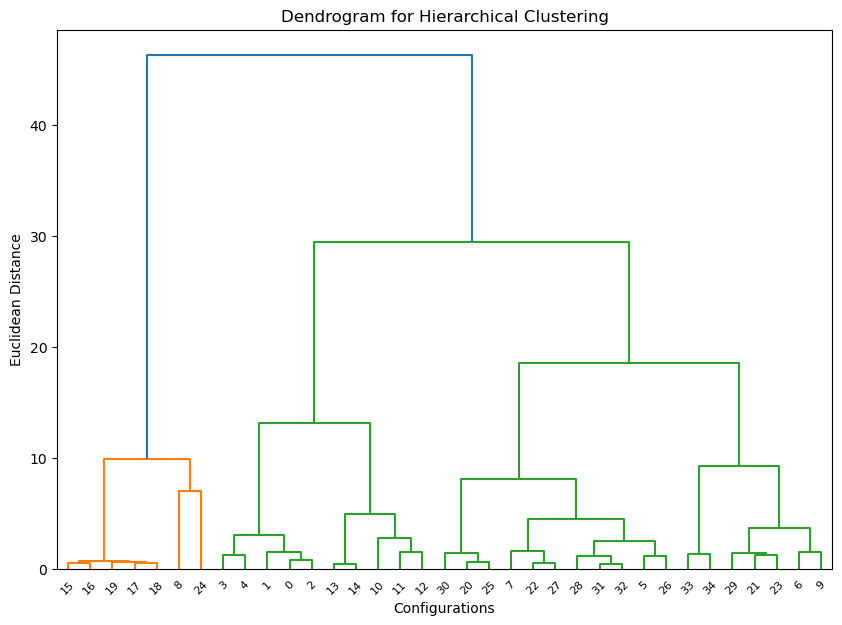

In [6]:
from scipy.cluster.hierarchy import dendrogram

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Configurations')
plt.ylabel('Euclidean Distance')
plt.show()


Assigns cluster labels to each configuration based on a maximum distance threshold and adds these labels to the aggregated matrix.

In [7]:
from scipy.cluster.hierarchy import fcluster

# Define the maximum distance threshold (e.g., 50)
max_distance = 25
clusters = fcluster(Z, max_distance, criterion='distance')

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster_Hierarchical'] = clusters


Groups configurations by cluster and general SPORE category, then counts the number of configurations in each group to summarize cluster composition.

In [8]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_Hierarchical', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count

spore_category_general,spores\maxbat,spores\maxbio,spores\maxhyd,spores\maxnuc,spores\minbat,spores\minhyd,spores\minnuc
Cluster_Hierarchical,,,,,,,
1,0,1,0,5,1,0,0
2,5,0,5,0,0,0,0
3,0,4,0,0,4,5,5


Calculates the mean (centroid) of each technology over time for each cluster, providing a summary profile for each cluster.

In [9]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# Show the resulting cluster summary
cluster_summary

timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-01-06 18:00:00,2019-01-06 21:00:00,2019-01-07 00:00:00,2019-01-07 03:00:00,2019-01-07 06:00:00,2019-01-07 09:00:00,2019-01-07 12:00:00,2019-01-07 15:00:00,2019-01-07 18:00:00,2019-01-07 21:00:00
Cluster_Hierarchical,,,,,,,,,,,,,,,,,,,,,
1,0.255832,0.259852,0.262068,0.265680,0.265678,0.266969,0.270523,0.269409,0.268683,0.264517,...,0.295503,0.279687,0.241596,0.256962,0.303265,0.296184,0.266695,0.270170,0.273038,0.280842
2,0.228145,0.230488,0.232979,0.232947,0.235297,0.239089,0.242680,0.238450,0.236516,0.234969,...,0.292285,0.262373,0.221593,0.236827,0.317804,0.287306,0.237470,0.238829,0.245043,0.249959
3,0.215401,0.218998,0.220976,0.223467,0.226775,0.229029,0.232352,0.230215,0.229150,0.226355,...,0.207753,0.201061,0.199190,0.202141,0.216538,0.220790,0.225282,0.232068,0.235500,0.240127


Plots the centroid time series for each cluster, showing how the average configuration in each cluster evolves over time.

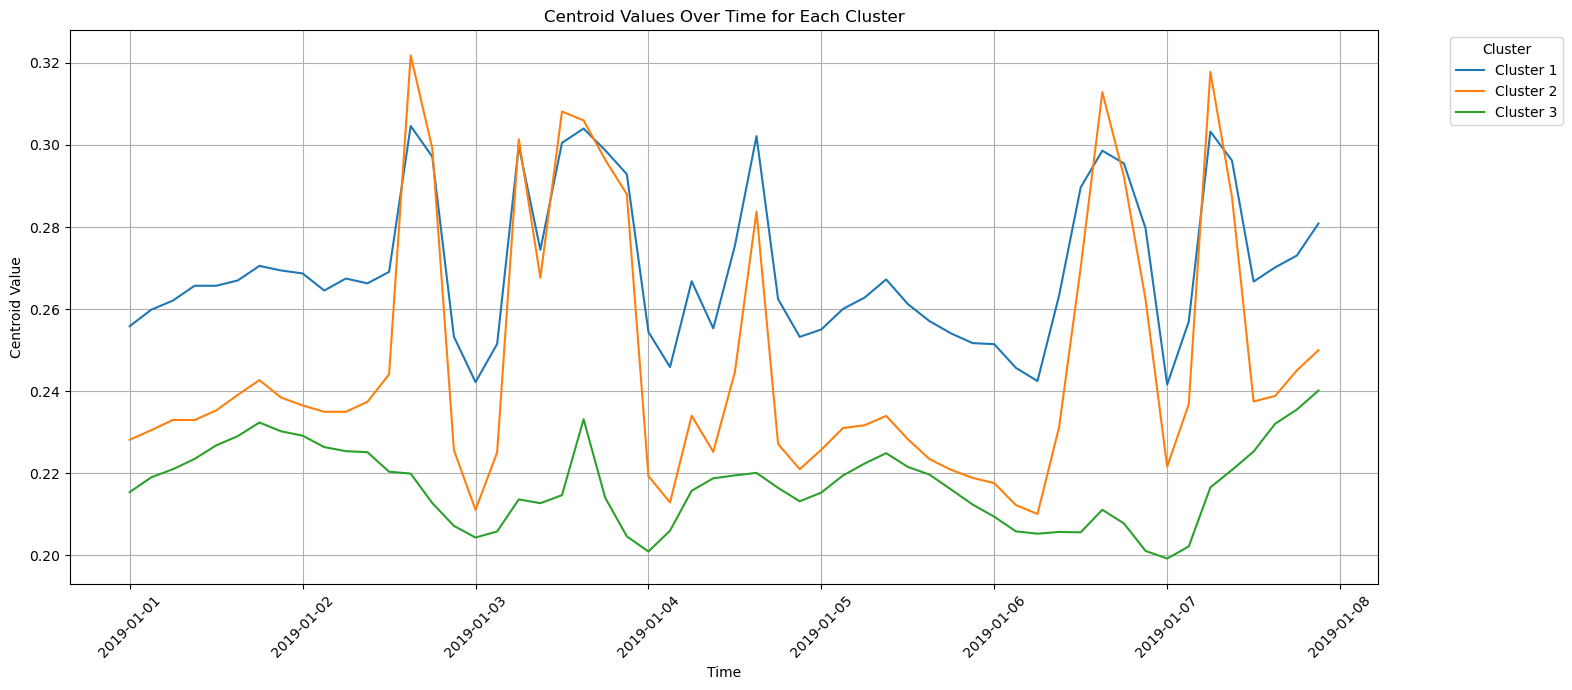

In [10]:
# Let's plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over time (columns)
for cluster in cluster_summary.index:
    plt.plot(cluster_summary.columns, cluster_summary.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Finds the configuration closest to the centroid for each cluster (the most representative configuration) and plots their time series.

Cluster 2 - Shape of cluster_configs: (10, 56)
Cluster 3 - Shape of cluster_configs: (18, 56)
Cluster 1 - Shape of cluster_configs: (7, 56)
Representative configurations: ['spores\\maxhyd_spore_1', 'spores\\minnuc_spore_2', 'spores\\maxnuc_spore_2']


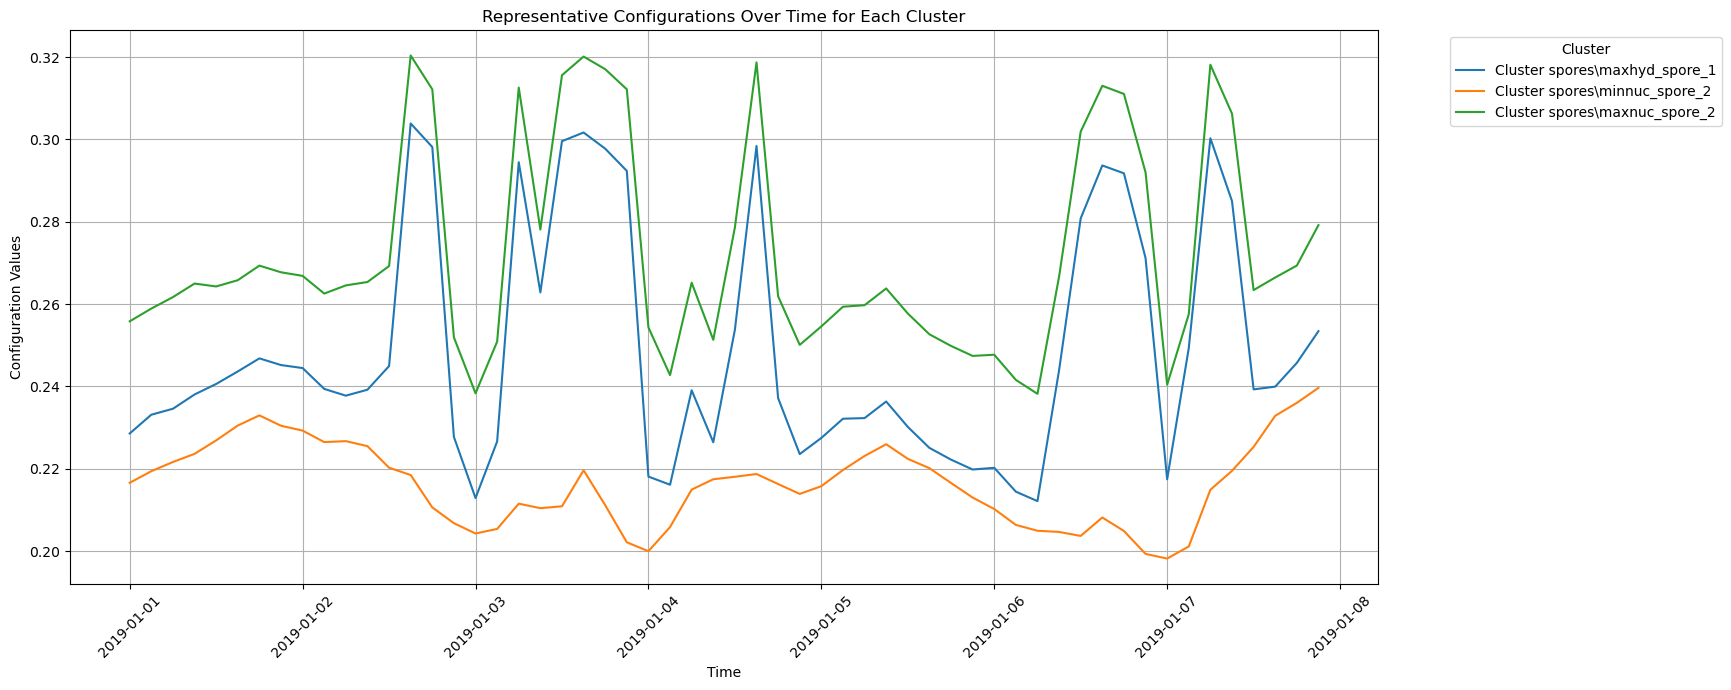

In [11]:
# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns

# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_Hierarchical'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_Hierarchical'] == cluster].drop(columns=['Cluster_Hierarchical'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs].drop(columns=['Cluster_Hierarchical'])

plt.figure(figsize=(14, 7))

# Loop through each configuration in 'df_representative_configs' and plot the time series for each cluster
for config in df_representative_configs.index:
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'Cluster {config}')

# Customize the plot
plt.title('Representative Configurations Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Configuration Values')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




Computes summary statistics (max, min, mean, variance, standard deviation, range, percentiles) for each representative configuration and displays them in a DataFrame.

In [12]:
# 1. Compute the metrics for each configuration
metrics = {
    'max_value': df_representative_configs.max(axis=1),
    'min_value': df_representative_configs.min(axis=1),
    'mean_value': df_representative_configs.mean(axis=1),
    'variance_value': df_representative_configs.var(axis=1),
    'std_dev_value': df_representative_configs.std(axis=1),
    'range_value': df_representative_configs.max(axis=1) - df_representative_configs.min(axis=1),
    'percentile_25': df_representative_configs.quantile(0.25, axis=1),
    'percentile_50': df_representative_configs.quantile(0.5, axis=1),
    'percentile_75': df_representative_configs.quantile(0.75, axis=1),
}

# Convert the metrics to a DataFrame for easy visualization
metrics_df = pd.DataFrame(metrics)

metrics_df

,max_value,min_value,mean_value,variance_value,std_dev_value,range_value,percentile_25,percentile_50,percentile_75
spores\maxhyd_spore_1,0.303875,0.212153,0.248781,0.000808,0.028421,0.091721,0.227678,0.239355,0.264944
spores\minnuc_spore_2,0.239673,0.198204,0.216322,0.000102,0.010083,0.041470,0.207837,0.216586,0.223251
spores\maxnuc_spore_2,0.320389,0.238213,0.272281,0.000638,0.025251,0.082176,0.254529,0.264774,0.282391


Performs linear regression on each representative configuration's time series to calculate the slope (trend) of each configuration.

In [13]:
from scipy.stats import linregress

# 1. Perform linear regression for each representative configuration
# and calculate the slope of the regression line
slopes = []
for config in df_representative_configs.index:
    time = np.arange(len(df_representative_configs.columns))  # Time indices for each timestep
    y = df_representative_configs.loc[config].values
    slope, _, _, _, _ = linregress(time, y)
    slopes.append(slope)

print(f"Slopes of the linear regression for each representative configuration: {slopes}")

Slopes of the linear regression for each representative configuration: [np.float64(8.655878433016884e-05), np.float64(-0.0001273275444823246), np.float64(7.339317633968643e-05)]


Plots the time series of each representative configuration along with its linear regression trend line for visual comparison.

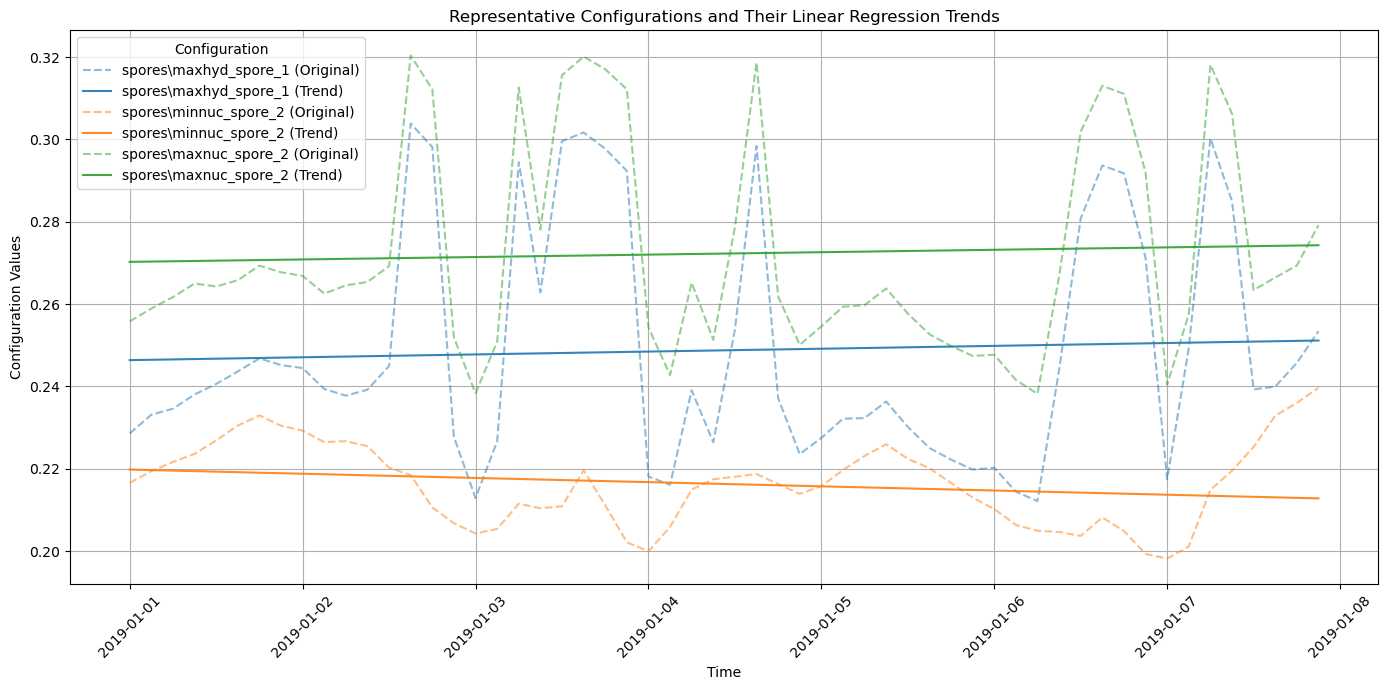

In [24]:
from scipy.stats import linregress
import matplotlib.cm as cm
# Plotting the representative configurations and their linear regression trends

# Initialize the plot
plt.figure(figsize=(14, 7))

# Loop through each representative configuration (row in df_representative_configs)
for i, config in enumerate(df_representative_configs.index):
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Perform linear regression to get the slope and intercept
    time = np.arange(len(config_data))  # Time indices for each timestep
    slope, intercept, _, _, _ = linregress(time, config_data.values)
    
    # Generate the regression line (linear trend)
    regression_line = slope * time + intercept
    
    # Use a colormap to assign a unique color for each configuration
    base_color = cm.tab10(i % 10)
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'{config} (Original)', linestyle='--', color=base_color, alpha=0.5)

    # Plot the linear regression line
    trend_color = base_color
    plt.plot(df_representative_configs.columns, regression_line, label=f'{config} (Trend)', linestyle='-', color=trend_color, alpha=0.9)

# Customize the plot
plt.title('Representative Configurations and Their Linear Regression Trends')
plt.xlabel('Time')
plt.ylabel('Configuration Values')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Configuration')
plt.show()